## Analysis of Covid-19 in Germany

This project was completed by Crispen Chisina, Zhanarbek Osmonaliev and Htet Naing Phyo.

In [105]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

covid_de = pd.read_csv('covid_germany/covid_de.csv')
demographics_de = pd.read_csv('covid_germany/demographics_de.csv')
google_covid_de = pd.read_csv("covid_germany/de_comp_covid.csv")

In [106]:
covid_de.head()

,state,county,age_group,gender,date,cases,deaths,recovered
0,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-27,1,0,1
1,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-28,1,0,1
2,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-04-03,1,0,1
3,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-18,1,0,1
4,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-22,1,0,1


In [107]:
demographics_de.head()

,state,gender,age_group,population
0,Baden-Wuerttemberg,female,00-04,261674
1,Baden-Wuerttemberg,female,05-14,490822
2,Baden-Wuerttemberg,female,15-34,1293488
3,Baden-Wuerttemberg,female,35-59,1919649
4,Baden-Wuerttemberg,female,60-79,1182736


# Data cleaning

In [108]:
covid_de.date = pd.to_datetime(covid_de.date, infer_datetime_format = True)
google_covid_de.date = pd.to_datetime(google_covid_de.date, infer_datetime_format = True)
#convert the date column in the covid dataset to date time format

In [109]:
covid_de.dtypes

state                object
county               object
age_group            object
gender               object
date         datetime64[ns]
cases                 int64
deaths                int64
recovered             int64
dtype: object

## Missing Values

In [110]:
covid_de.isnull().sum()
# check for missing values

state            0
county           0
age_group     2244
gender       13916
date             0
cases            0
deaths           0
recovered        0
dtype: int64

In [111]:
demographics_de.isnull().sum()

state         0
gender        0
age_group     0
population    0
dtype: int64

In [112]:
covid_de[covid_de['gender'].isnull()].head(5)

,state,county,age_group,gender,date,cases,deaths,recovered
315,Baden-Wuerttemberg,LK Alb-Donau-Kreis,05-14,NaN,2020-10-30,1,0,1
316,Baden-Wuerttemberg,LK Alb-Donau-Kreis,05-14,NaN,2020-11-19,1,0,1
798,Baden-Wuerttemberg,LK Alb-Donau-Kreis,15-34,NaN,2020-10-28,1,0,1
799,Baden-Wuerttemberg,LK Alb-Donau-Kreis,15-34,NaN,2020-10-30,2,0,2
800,Baden-Wuerttemberg,LK Alb-Donau-Kreis,15-34,NaN,2020-11-01,1,0,1


In [113]:
covid_de[covid_de['age_group'].isnull()].head(5)

,state,county,age_group,gender,date,cases,deaths,recovered
1919,Baden-Wuerttemberg,LK Alb-Donau-Kreis,NaN,F,2020-10-26,1,0,1
1920,Baden-Wuerttemberg,LK Alb-Donau-Kreis,NaN,F,2020-11-19,1,0,1
1921,Baden-Wuerttemberg,LK Alb-Donau-Kreis,NaN,F,2020-12-24,1,0,1
1922,Baden-Wuerttemberg,LK Alb-Donau-Kreis,NaN,M,2021-03-31,1,0,0
6114,Baden-Wuerttemberg,LK Boeblingen,NaN,M,2021-01-30,1,0,1


In [114]:
covid_de['age_group'].isnull().sum()/len(covid_de) * 100

# only 0.3246% in the age group column are missing so we can just drop the rows since it is a very small'
# percentages

0.32464056618240633

In [115]:
covid_de['gender'].isnull().sum()/len(covid_de) * 100
# only 2.01% of the entries in the gender column are missing so we can just drop the rows since it is a very small
# percentages

2.0132344558798425

In [116]:
# drop missing rows in age group rows
covid_de = covid_de[covid_de['age_group'].notna()]

In [117]:
# drop missing rows in gender group rows
covid_df = covid_de[covid_de['gender'].notna()]

In [118]:
covid_df.isnull().sum()

state        0
county       0
age_group    0
gender       0
date         0
cases        0
deaths       0
recovered    0
dtype: int64

In [119]:
vital_attributes = ["date", "new_confirmed", "new_deceased", "new_persons_fully_vaccinated", "mobility_retail_and_recreation", "mobility_grocery_and_pharmacy", "mobility_parks", "mobility_transit_stations", "mobility_workplaces", "mobility_residential", "testing_policy", "facial_coverings", "vaccination_policy", "average_temperature_celsius"]
google_covid_de.drop(google_covid_de.columns.difference(vital_attributes), axis=1, inplace=True)

## Duplicates

In [120]:
print('number of duplicated rows in "covid" :', covid_df.duplicated().sum())
print('')
print('number of duplicated rows in "demographics" :', demographics_de.duplicated().sum())

number of duplicated rows in "covid" : 0

number of duplicated rows in "demographics" : 0


In [121]:
# drop duplicate entries
covid_df = covid_df.drop_duplicates()
print('number of duplicated rows in "covid" :', covid_df.duplicated().sum())

number of duplicated rows in "covid" : 0


## Outliers

<AxesSubplot:>

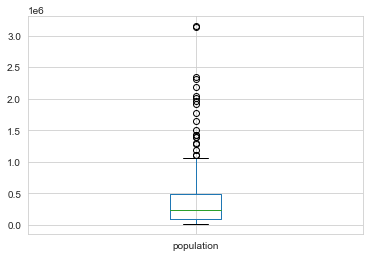

In [122]:
demographics_de.boxplot()

In [123]:
def outliers_loc(df, feature):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5*iqr
    lower_bound = q1 - 1.5*iqr
    ind = df.index[(df[feature] <= lower_bound) | (df[feature] >= upper_bound)]
    return ind

# function to detect location of outliers using Interquartile range

In [124]:
def remove_out(df, indexes_ls):
    out_index_ls = sorted(set(indexes_ls))
    df = df.drop(out_index_ls)
    return df
# function to remove outliers given the location of the outliers

In [125]:
outlrs_loc = outliers_loc(demographics_de, 'population')
print('number of outliers in "demographics_de" :', len(outlrs_loc))

number of outliers in "demographics_de" : 21


In [126]:
new_demographics_cleaned =  remove_out(demographics_de, outlrs_loc)

<AxesSubplot:>

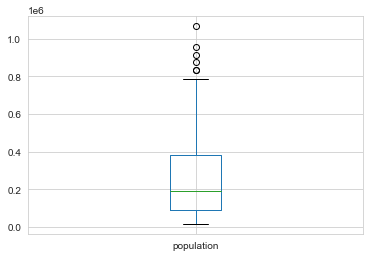

In [127]:
new_demographics_cleaned.boxplot()

In [128]:
len(outliers_loc(new_demographics_cleaned, 'population'))
# most of the outliers have been removed since
# we can not completely remove all outliers the 
# remaining 6 are negligable so we can leave them in the dataset

6

<AxesSubplot:>

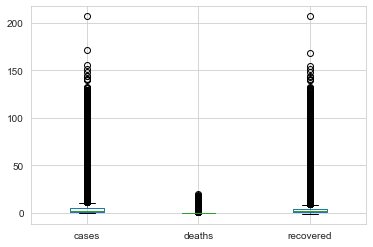

In [129]:
covid_df.boxplot()
# the covid dataset has alot of outliers

In [130]:
outlrs_indexes = outliers_loc(covid_df, 'cases')

In [131]:
len(outlrs_indexes)

59162

In [132]:
new_covid_df_cleaned =  remove_out(covid_df, outlrs_indexes)

<AxesSubplot:>

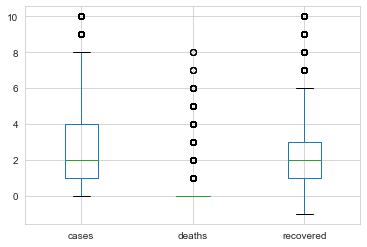

In [133]:
new_covid_df_cleaned.boxplot()
# most of the outliers have been removed and since we can not remove all
# we can just leave the remaining

In [134]:
new_demographics_cleaned = new_demographics_cleaned.replace(['female', 'male'], ['F', 'M'])

In [135]:
merged_data = new_covid_df_cleaned.merge(new_demographics_cleaned,
                                         how = 'inner', on = ['state', 'gender', 'age_group'])

# merge the cleaned demographics and covid dataset

In [136]:
merged_data.shape

(385640, 9)

__final data sets new_covid_df_cleaned, new_demographics_cleaned and merged_data__

#### Cleaning and Filling Missing Values in the Additional Dataset

1)  We will select the data starting from February 21th 2020 till May 2nd 2022, as it has almost no missing values.

2) Next, we fill in empty values in `new_persons_fully_vaccinated` and `cumulative_persons_fully_vaccinated` with 0s, since there were no vaccinated people recorded in the beginning of the pandemic.

3) Lastly, we drop incomplete columns, as the number of them is negligible in relation to the whole dataset.

In [137]:
google_covid_de.isnull().sum()

date                                0
new_confirmed                       5
new_deceased                        5
new_persons_fully_vaccinated      371
mobility_retail_and_recreation     50
mobility_grocery_and_pharmacy      50
mobility_parks                     50
mobility_transit_stations          50
mobility_workplaces                50
mobility_residential               50
testing_policy                      6
facial_coverings                    6
vaccination_policy                  6
average_temperature_celsius         9
dtype: int64

In [138]:
google_covid_de['new_persons_fully_vaccinated'] = google_covid_de['new_persons_fully_vaccinated'].fillna(0)
google_covid_de = google_covid_de[51:851]
google_covid_de.isnull().sum()

date                              0
new_confirmed                     0
new_deceased                      0
new_persons_fully_vaccinated      0
mobility_retail_and_recreation    0
mobility_grocery_and_pharmacy     0
mobility_parks                    0
mobility_transit_stations         0
mobility_workplaces               0
mobility_residential              0
testing_policy                    0
facial_coverings                  0
vaccination_policy                0
average_temperature_celsius       1
dtype: int64

In [139]:
google_covid_de = google_covid_de[google_covid_de['average_temperature_celsius'].notna()]
google_covid_de.isnull().sum()

date                              0
new_confirmed                     0
new_deceased                      0
new_persons_fully_vaccinated      0
mobility_retail_and_recreation    0
mobility_grocery_and_pharmacy     0
mobility_parks                    0
mobility_transit_stations         0
mobility_workplaces               0
mobility_residential              0
testing_policy                    0
facial_coverings                  0
vaccination_policy                0
average_temperature_celsius       0
dtype: int64

# Data Analysis

## Covid cases trend in Germany

In [140]:
covidcases_bydate = new_covid_df_cleaned.groupby('date').sum()
# find the sum for cases, deaths and recovered by date in order to visualize trends

In [141]:
covidcases_bydate.head()

,cases,deaths,recovered
date,,,
2020-01-07,1,0,1
2020-01-19,1,0,1
2020-01-23,1,0,1
2020-01-25,1,0,1
2020-01-28,2,0,2


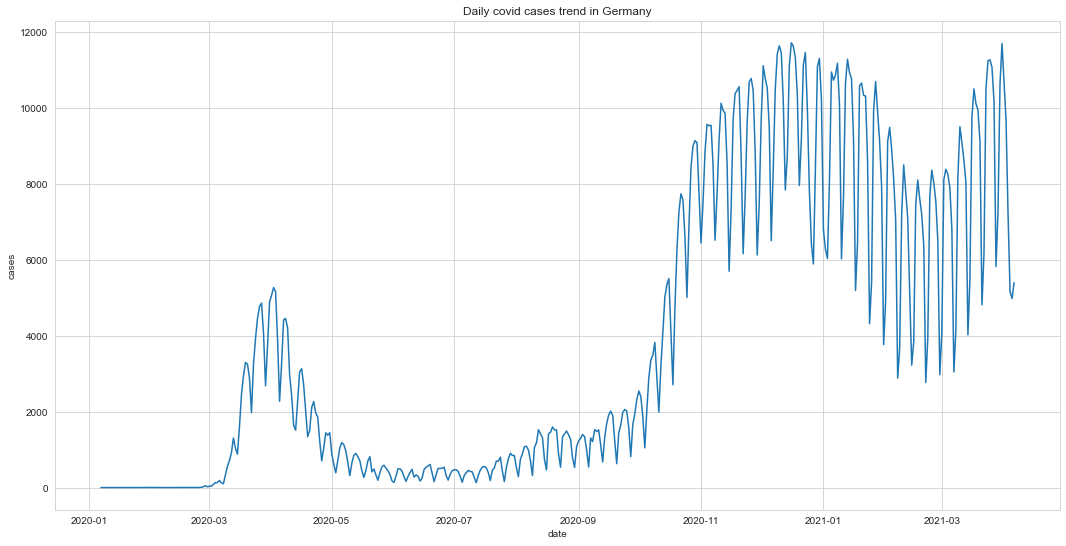

In [142]:
from matplotlib.gridspec import GridSpec

sns.set_style("whitegrid")
plt.figure(figsize=(18,9))
plt.title('Daily covid cases trend in Germany')
p=sns.lineplot(data=covidcases_bydate.cases)

* From the graph above it looks like there was a slight peak betwen March 2020 and May 2020, which was the time corona spread but there was a decline in cases after maybe because of lockdown measures
* However, there was a second wave in the start of 2021 because of the new variant and the number of cases peaked near the start of 2021.
* Moreover it also looks like in april there was another wave of surge of number of cases in april 2021

## Trend of cases by states

In [143]:
covid_bystate = new_covid_df_cleaned.groupby(by=["state", "date"]).sum()
# find the sum for cases, deaths and recovered by date and state in order to visualize trends

In [144]:
covid_bystate.reset_index(inplace=True)

In [145]:
covid_bystate.head()

,state,date,cases,deaths,recovered
0,Baden-Wuerttemberg,2020-02-24,1,0,1
1,Baden-Wuerttemberg,2020-02-25,2,0,2
2,Baden-Wuerttemberg,2020-02-26,4,0,4
3,Baden-Wuerttemberg,2020-02-27,3,0,3
4,Baden-Wuerttemberg,2020-02-28,7,0,7


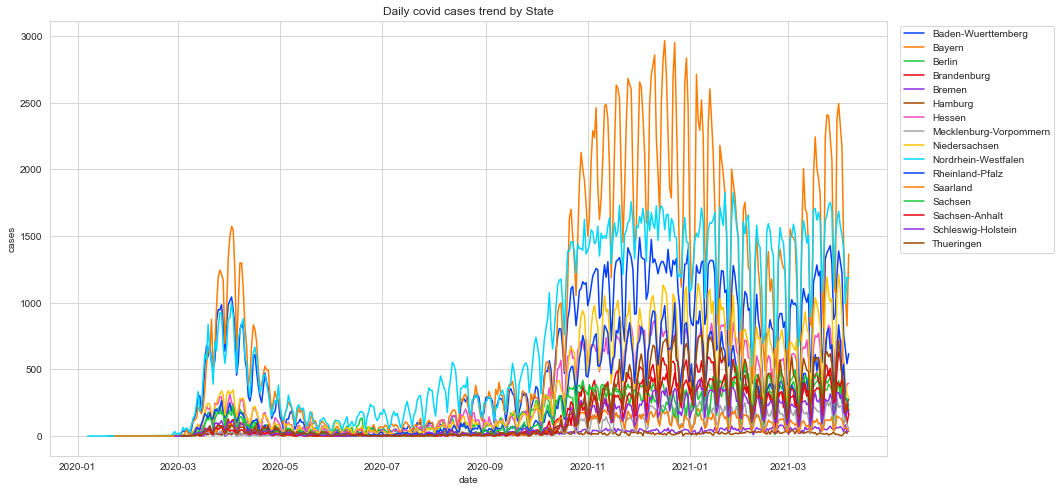

In [146]:
plt.figure(figsize=(15,8))
ln = sns.lineplot(data=covid_bystate, x="date", y="cases", hue="state", palette = 'bright')
ln.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.title("Daily covid cases trend by State")
plt.show()

* from the graph above one can see that in the peak monnths Bayern contributed more in the rise of cases in Germany
* however just comparing the numbers can be misleading because population sizes also plays a key part so it is bettter to compare the ratios population

In [147]:
cov_demo_df = merged_data.copy()

cov_demo_df['Cases per population'] = merged_data.cases/merged_data.population

cov_demo_df['Deaths per population'] = merged_data.deaths/merged_data.population

In [148]:
state_data = cov_demo_df.groupby('state').sum().sort_values('Cases per population', ascending=False)
state_data['Fatality'] = (state_data.deaths / state_data.cases) * 100

In [149]:
state_data.head()

,cases,deaths,recovered,population,Cases per population,Deaths per population,Fatality
state,,,,,,,
Thueringen,75904,2922,67032,6242867987,0.438883,0.031175,3.849599
Brandenburg,65225,2678,57138,6002839509,0.326002,0.024993,4.105788
Saarland,24061,732,22147,936841656,0.312279,0.017114,3.042268
Sachsen-Anhalt,52541,2021,45324,4043605652,0.306906,0.020174,3.846520
Rheinland-Pfalz,104470,2958,93558,19854720609,0.299543,0.017746,2.831435


[]

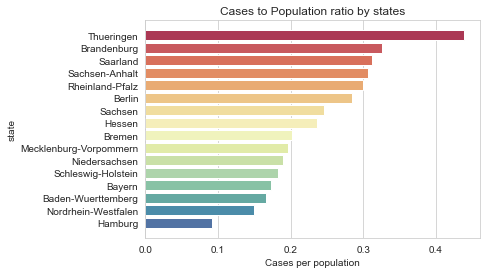

In [150]:
sns.barplot(data = state_data, x='Cases per population', y=state_data.index, palette='Spectral')
plt.title("Cases to Population ratio by states")
plt.plot()

* From the graph above one can see the full story that although Bayern contributed more to the spike in covid cases because it has a larger population but when we compare cases to population ratio bayern is one of the bottom 4 but Thueringen had the highest.

## Rates of Cases by State

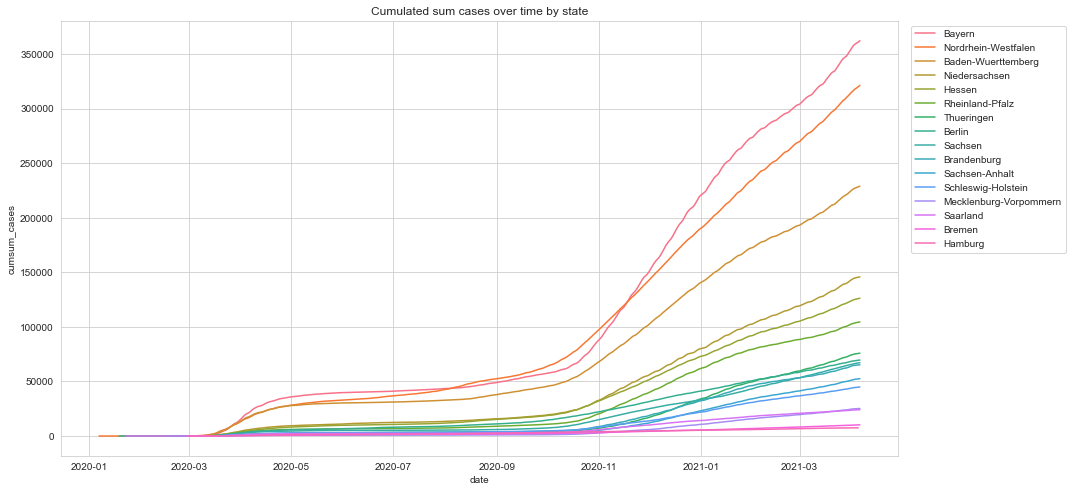

In [151]:
state_sum = new_covid_df_cleaned.groupby(by=["state", "date"]).sum()
state_sum = state_sum.replace([np.inf, -np.inf], 0)
state_sum["cumsum_cases"] = state_sum.groupby(level=-2)["cases"].cumsum()
state_sum = state_sum.reset_index()

plt.figure(figsize=(15,8))
ln = sns.lineplot(data=state_sum.sort_values("cumsum_cases", ascending=False), x="date", y="cumsum_cases", hue="state")
ln.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.title("Cumulated sum cases over time by state")
plt.show()

* from the graph above one can see that Bayern had the highest increasing rate and Hamburg had the lowest increasing rate

## Trend of Death by State

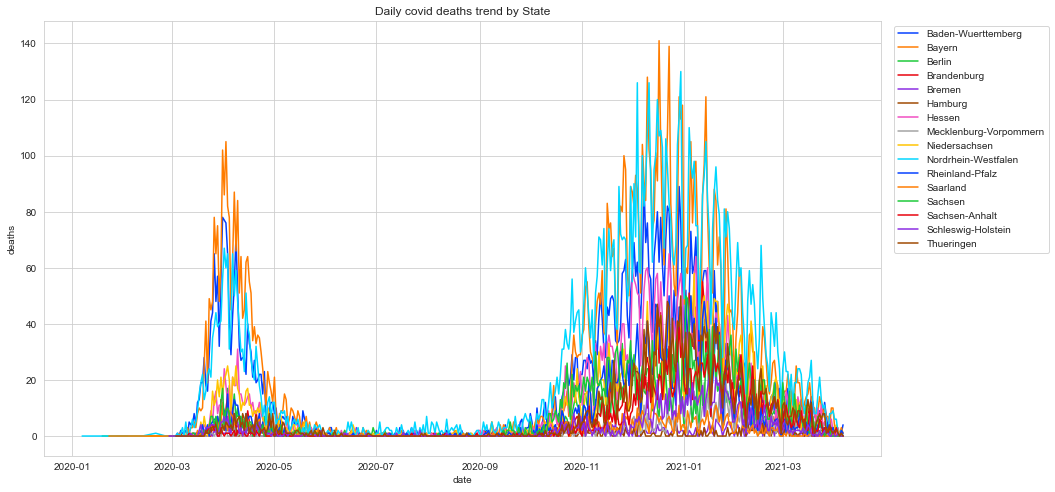

In [152]:
plt.figure(figsize=(15, 8))
ln = sns.lineplot(data=covid_bystate, x="date", y="deaths",
                  hue="state", palette='bright')
ln.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.title("Daily covid deaths trend by State")
plt.show()

* Highest deaths occured in Bayern and Nordhein-Westfalen states.
* Death cases in Nordhein-Westfalen seems to be relatively frequent even during the months when the cases died down. 

In [153]:
state_data = state_data.sort_values('Deaths per population', ascending=False)

[]

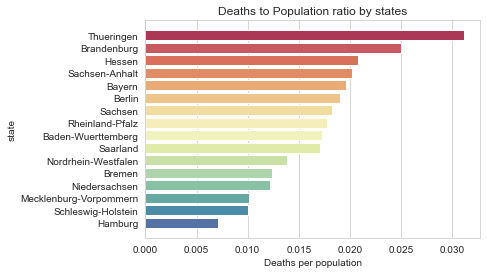

In [154]:

sns.barplot(data=state_data, x='Deaths per population',
            y=state_data.index, palette='Spectral')
plt.title("Deaths to Population ratio by states")
plt.plot()

* Supporting results in previous cases to population ratio graphs, Theringen state had highest Deaths to Population ratio. 

In [155]:
state_data = state_data.sort_values('Fatality', ascending=False)


[]

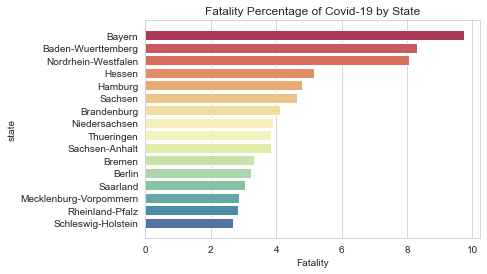

In [156]:
sns.barplot(data=state_data, x='Fatality',
            y=state_data.index, palette='Spectral')
plt.title("Fatality Percentage of Covid-19 by State")
plt.plot()


* Eventhough Death to Population ratio was smaller in state such as Bayern, in terms of Fatality, it is showing that states with bigger population and higher cases had more fatalities. 
* For example, in Bayern, almost 10 percent of covid cases passed away where in Schleswig-Holstein, only 2 percent of death. 

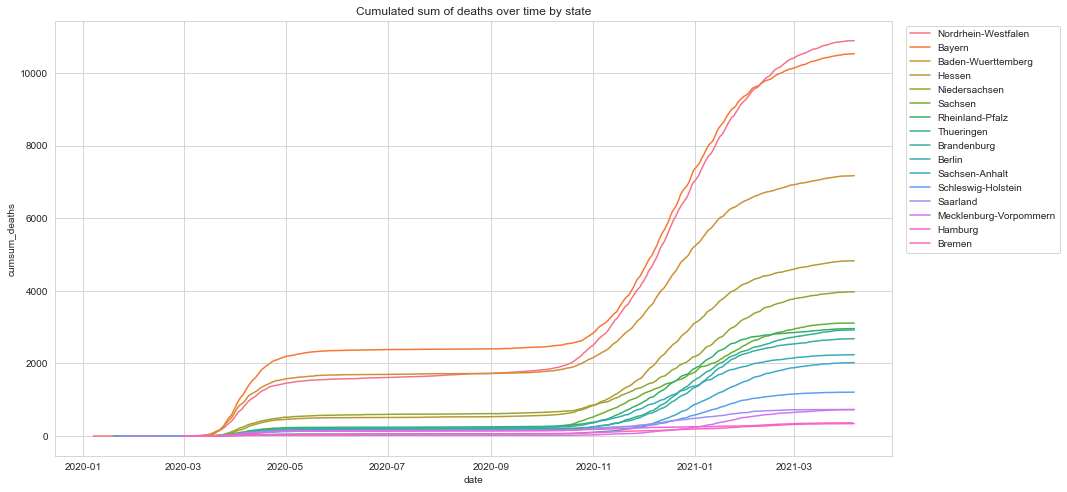

In [157]:
state_sum = new_covid_df_cleaned.groupby(by=["state", "date"]).sum()
state_sum = state_sum.replace([np.inf, -np.inf], 0)
state_sum["cumsum_deaths"] = state_sum.groupby(level=-2)["deaths"].cumsum()
state_sum = state_sum.reset_index()

plt.figure(figsize=(15, 8))
ln = sns.lineplot(data=state_sum.sort_values(
    "cumsum_deaths", ascending=False), x="date", y="cumsum_deaths", hue="state")
ln.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.title("Cumulated sum of deaths over time by state")
plt.show()


* Nodhein-Westfalen has the highest rate of increasing death rate and lowest one is Bremen. 

## Age and Gender

In [158]:
merged_data.head()

,state,county,age_group,gender,date,cases,deaths,recovered,population
0,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-27,1,0,1,261674
1,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-28,1,0,1,261674
2,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-04-03,1,0,1,261674
3,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-18,1,0,1,261674
4,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-22,1,0,1,261674


In [159]:
covidcases_by_age_group = new_covid_df_cleaned.groupby('age_group').sum()
covidcases_by_age_group= covidcases_by_age_group.reset_index()
covidcases_by_age_group.head(6)

,age_group,cases,deaths,recovered
0,00-04,63146,8,54523
1,05-14,165341,7,147330
2,15-34,466144,75,433436
3,35-59,508872,1383,474218
4,60-79,338541,16057,297036
5,80-99,189010,39142,141246


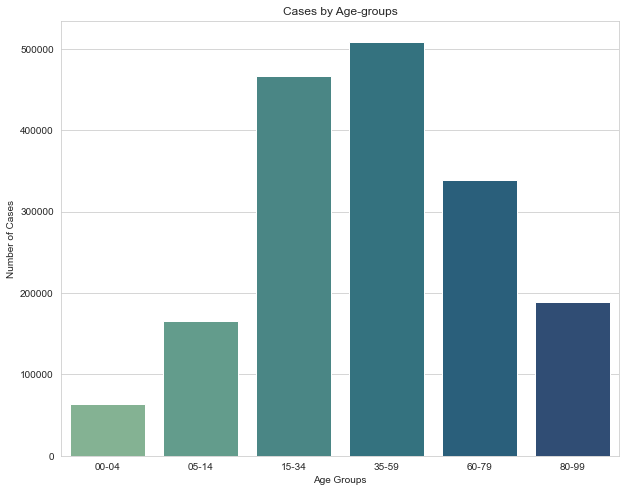

In [160]:
plt.figure(figsize=(10, 8))
sns.barplot(data = covidcases_by_age_group,  x = "age_group", y = "cases", palette="crest")
plt.title("Cases by Age-groups")
plt.xlabel('Age Groups')
plt.ylabel('Number of Cases')
plt.show()


* Age group of 35-59 has highest number of cases, followed by the group of 15-34, which are the age ranges that tend to commute to public places more. 
* Age group of 0-4 has lowest number of cases. 

In [161]:
covidcases_by_gender = new_covid_df_cleaned.groupby('gender').sum()
covidcases_by_gender = covidcases_by_gender.reset_index()
covidcases_by_gender.head(6)


,gender,cases,deaths,recovered
0,F,872639,23825,785950
1,M,858415,32847,761839


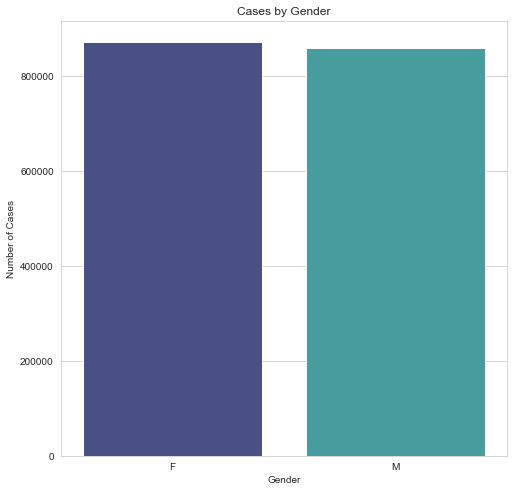

In [162]:
plt.figure(figsize=(8, 8))
sns.barplot(data = covidcases_by_gender, x="gender", y = "cases", palette="mako")
plt.title("Cases by Gender")
plt.xlabel('Gender')
plt.ylabel('Number of Cases')
plt.show()

* Female Covid 19 cases are higher than that of male only by a small margin. It can be concluded that Covid-19 cases occur equally in both genders. 

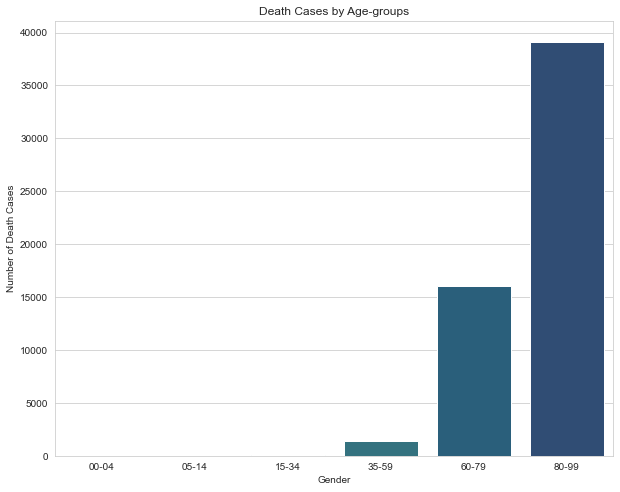

In [163]:
plt.figure(figsize=(10, 8))
sns.barplot(data=covidcases_by_age_group,
            x="age_group", y="deaths", palette="crest")
plt.title("Death Cases by Age-groups")
plt.xlabel('Gender')
plt.ylabel('Number of Death Cases')
plt.show()

* Even though age group of 80-99 has relatively lower cases by number, the death cases are around twice of other age-group combined. 

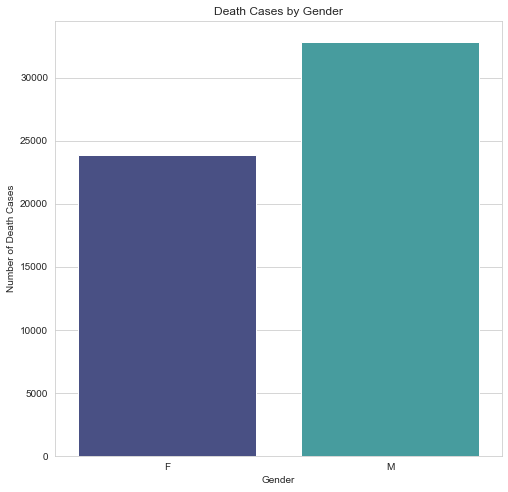

In [164]:
plt.figure(figsize=(8, 8))
sns.barplot(data=covidcases_by_gender, x="gender", y="deaths", palette="mako")
plt.title("Death Cases by Gender")
plt.xlabel('Gender')
plt.ylabel('Number of Death Cases')
plt.show()

* Covid-19 related deaths of males are relatively higher compared to females. 

#### What contributes to the spread of COVID-19 in Germany?
* When it comes to understanding what contributes to the spread of Covid-19 in Germany, we need to use an additonal dataset provided GoogleCloudPlatform. More info here [open-covid-19.github.io](https://open-covid-19.github.io/explorer/report/?key=DE)

<AxesSubplot:>

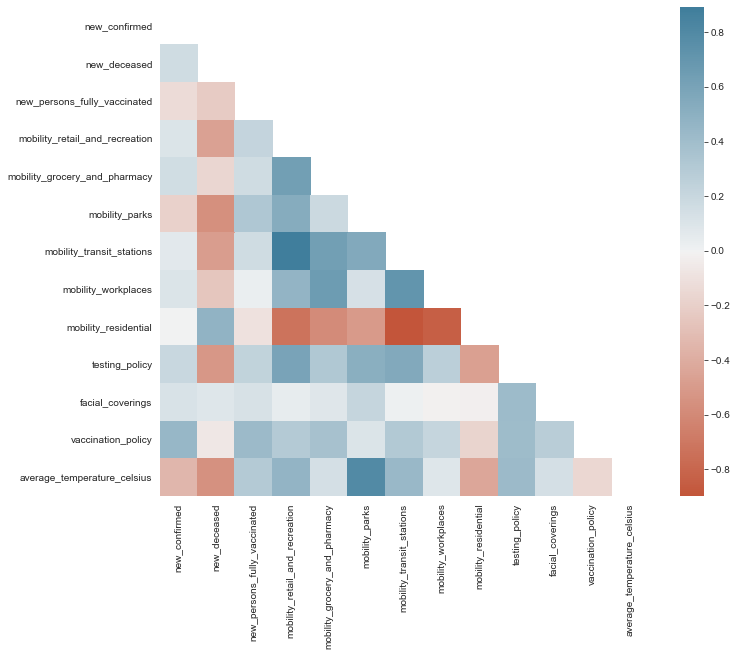

In [165]:
corr = google_covid_de.corr()
f, ax = plt.subplots(figsize=(11,9))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(20, 230, as_cmap=True)
sns.heatmap(corr, cmap=cmap, square=True, mask=mask)

* By looking at the correlation table, we can see that `new confirmed cases` are negatively correlated with the average temperature. Meaning when the weather is colder, people tend to be sick more often.

* In addition to that, let's analyze how people's movement affects the spread of COVID-19.

<AxesSubplot:label='eb7a6581-176e-40d7-9a15-9e50c84b0e39', xlabel='date', ylabel='mobility_retail_and_recreation'>

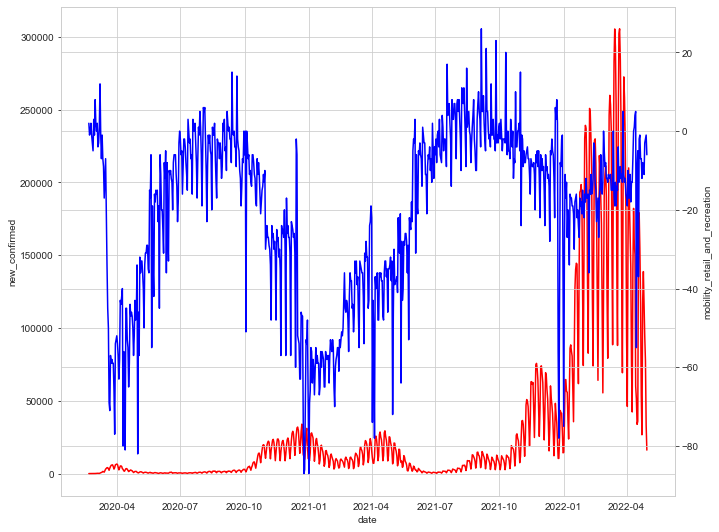

In [166]:
plt.figure(figsize=(11,9))
sns.lineplot(x='date', y='new_confirmed', data=google_covid_de, color='r')
ax2 = plt.twinx()
sns.lineplot(x='date', y='mobility_retail_and_recreation', data=google_covid_de, color='b', ax=ax2)

# Modeling

## Data Preprocessing

In [167]:
cov_model_df = new_covid_df_cleaned.groupby(by=["state", "county", 'age_group', 'gender']).sum()
# calculate the sum of cases deaths and recovered and cases for each gender, age_group, county and state

In [168]:
cov_model_df.reset_index(inplace=True)

In [169]:
new_merged = cov_model_df.merge(new_demographics_cleaned,
                                         how = 'inner', on = ['state', 'gender', 'age_group'])
# merge the demographics data in order to obtain population

In [170]:
new_merged.head()

,state,county,age_group,gender,cases,deaths,recovered,population
0,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,49,0,41,261674
1,Baden-Wuerttemberg,LK Biberach,00-04,F,49,0,44,261674
2,Baden-Wuerttemberg,LK Bodenseekreis,00-04,F,46,0,43,261674
3,Baden-Wuerttemberg,LK Boeblingen,00-04,F,121,0,108,261674
4,Baden-Wuerttemberg,LK Breisgau-Hochschwarzwald,00-04,F,76,0,70,261674


In [171]:
new_merged = new_merged.replace(['F', 'M'], [1, 0])
# Female -> 1 and Male -> 0

In [172]:
new_merged['deaths'] = np.where(new_merged['deaths']> 0 , 1, 0)
# dead -> 1 and survived -> 0

In [173]:
new_merged.isnull().sum()

state         0
county        0
age_group     0
gender        0
cases         0
deaths        0
recovered     0
population    0
dtype: int64

In [174]:
new_merged.head()

,state,county,age_group,gender,cases,deaths,recovered,population
0,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,1,49,0,41,261674
1,Baden-Wuerttemberg,LK Biberach,00-04,1,49,0,44,261674
2,Baden-Wuerttemberg,LK Bodenseekreis,00-04,1,46,0,43,261674
3,Baden-Wuerttemberg,LK Boeblingen,00-04,1,121,0,108,261674
4,Baden-Wuerttemberg,LK Breisgau-Hochschwarzwald,00-04,1,76,0,70,261674


In [175]:
new_merged['deaths'].value_counts()
# the data is balanced so no preprocessing needed

0    2123
1    1565
Name: deaths, dtype: int64

In [176]:
state = pd.get_dummies(new_merged['state'], drop_first = True)
# since state is a string vairable, convert it to dummy vairable since the models dnt work on string object

In [177]:
county = pd.get_dummies(new_merged['county'], drop_first = True)
# since county is a string vairable, convert it to dummy vairable since the models dnt work on string object

In [178]:
age_group = pd.get_dummies(new_merged['age_group'], drop_first = True)
# since age_group is a string vairable, convert it to dummy vairable since the models dnt work on string object

In [179]:
new_combined_with_dums = pd.concat([new_merged, state, county, age_group], axis = 1)
# concatinate the dummy clomuns to the main data frame

In [180]:
new_combined_with_dums.head()

,state,county,age_group,gender,cases,deaths,recovered,population,Bayern,Berlin,...,SK Worms,SK Wuerzburg,SK Wuppertal,SK Zweibruecken,StadtRegion Aachen,05-14,15-34,35-59,60-79,80-99
0,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,1,49,0,41,261674,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Baden-Wuerttemberg,LK Biberach,00-04,1,49,0,44,261674,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Baden-Wuerttemberg,LK Bodenseekreis,00-04,1,46,0,43,261674,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Baden-Wuerttemberg,LK Boeblingen,00-04,1,121,0,108,261674,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Baden-Wuerttemberg,LK Breisgau-Hochschwarzwald,00-04,1,76,0,70,261674,0,0,...,0,0,0,0,0,0,0,0,0,0


In [181]:
new_combined_with_dums.drop(['county', 'state', 'age_group'], axis = 1, inplace = True)
# drop non numeric columns

In [182]:
new_combined_with_dums.describe()

,gender,cases,deaths,recovered,population,Bayern,Berlin,Brandenburg,Bremen,Hamburg,...,SK Worms,SK Wuerzburg,SK Wuppertal,SK Zweibruecken,StadtRegion Aachen,05-14,15-34,35-59,60-79,80-99
count,3688.000000,3688.000000,3688.000000,3688.000000,3.688000e+03,3688.000000,3688.000000,3688.000000,3688.000000,3688.000000,...,3688.000000,3688.000000,3688.000000,3688.000000,3688.000000,3688.000000,3688.000000,3688.000000,3688.000000,3688.000000
mean,0.494035,265.379881,0.424349,231.152657,3.680934e+05,0.156182,0.039046,0.058568,0.006508,0.003254,...,0.003254,0.001627,0.001627,0.003254,0.001627,0.223427,0.118764,0.080260,0.130694,0.223427
std,0.500032,213.716931,0.494311,194.672930,2.468399e+05,0.363077,0.193730,0.234847,0.080418,0.056957,...,0.056957,0.040307,0.040307,0.056957,0.040307,0.416599,0.323554,0.271733,0.337111,0.416599
min,0.000000,3.000000,0.000000,2.000000,1.590600e+04,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,90.000000,0.000000,75.000000,1.721360e+05,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,195.500000,0.000000,161.000000,3.216290e+05,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,413.000000,1.000000,357.000000,4.908220e+05,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,979.000000,1.000000,881.000000,1.065669e+06,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [183]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X=new_combined_with_dums.drop('deaths', axis = 1)  # Features
y=new_combined_with_dums['deaths']  # Labels

# Feature Scaling

X_scaled = pd.DataFrame(sc.fit_transform(X), columns = X.columns)
# the data needs to be scaled because of different ranges

In [184]:
X_scaled.describe()

,gender,cases,recovered,population,Bayern,Berlin,Brandenburg,Bremen,Hamburg,Hessen,...,SK Worms,SK Wuerzburg,SK Wuppertal,SK Zweibruecken,StadtRegion Aachen,05-14,15-34,35-59,60-79,80-99
count,3.688000e+03,3.688000e+03,3.688000e+03,3.688000e+03,3.688000e+03,3.688000e+03,3.688000e+03,3.688000e+03,3.688000e+03,3.688000e+03,...,3.688000e+03,3.688000e+03,3.688000e+03,3.688000e+03,3.688000e+03,3.688000e+03,3.688000e+03,3.688000e+03,3.688000e+03,3.688000e+03
mean,-4.089883e-16,-1.423903e-17,-2.095215e-17,-1.132379e-15,-1.661039e-14,6.424874e-16,-9.363578e-15,1.709737e-15,4.748062e-16,9.143385e-16,...,6.635863e-16,-4.527290e-16,-4.704864e-16,6.674396e-16,-4.704864e-16,4.154486e-15,3.793513e-15,-1.519091e-15,-3.531731e-15,1.352256e-16
std,1.000136e+00,1.000136e+00,1.000136e+00,1.000136e+00,1.000136e+00,1.000136e+00,1.000136e+00,1.000136e+00,1.000136e+00,1.000136e+00,...,1.000136e+00,1.000136e+00,1.000136e+00,1.000136e+00,1.000136e+00,1.000136e+00,1.000136e+00,1.000136e+00,1.000136e+00,1.000136e+00
min,-9.881397e-01,-1.227865e+00,-1.177276e+00,-1.426979e+00,-4.302208e-01,-2.015739e-01,-2.494233e-01,-8.093342e-02,-5.713508e-02,-2.754015e-01,...,-5.713508e-02,-4.036767e-02,-4.036767e-02,-5.713508e-02,-4.036767e-02,-5.363856e-01,-3.671093e-01,-2.954051e-01,-3.877410e-01,-5.363856e-01
25%,-9.881397e-01,-8.207289e-01,-8.022370e-01,-7.939723e-01,-4.302208e-01,-2.015739e-01,-2.494233e-01,-8.093342e-02,-5.713508e-02,-2.754015e-01,...,-5.713508e-02,-4.036767e-02,-4.036767e-02,-5.713508e-02,-4.036767e-02,-5.363856e-01,-3.671093e-01,-2.954051e-01,-3.877410e-01,-5.363856e-01
50%,-9.881397e-01,-3.270183e-01,-3.604105e-01,-1.882627e-01,-4.302208e-01,-2.015739e-01,-2.494233e-01,-8.093342e-02,-5.713508e-02,-2.754015e-01,...,-5.713508e-02,-4.036767e-02,-4.036767e-02,-5.713508e-02,-4.036767e-02,-5.363856e-01,-3.671093e-01,-2.954051e-01,-3.877410e-01,-5.363856e-01
75%,1.012003e+00,6.908210e-01,6.465429e-01,4.972665e-01,-4.302208e-01,-2.015739e-01,-2.494233e-01,-8.093342e-02,-5.713508e-02,-2.754015e-01,...,-5.713508e-02,-4.036767e-02,-4.036767e-02,-5.713508e-02,-4.036767e-02,-5.363856e-01,-3.671093e-01,-2.954051e-01,-3.877410e-01,-5.363856e-01
max,1.012003e+00,3.339543e+00,3.338602e+00,2.826408e+00,2.324388e+00,4.960959e+00,4.009249e+00,1.235584e+01,1.750238e+01,3.631063e+00,...,1.750238e+01,2.477230e+01,2.477230e+01,1.750238e+01,2.477230e+01,1.864330e+00,2.723984e+00,3.385182e+00,2.579041e+00,1.864330e+00


## Training and Testing

In [185]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

## Logistic Regression Modeling and Evaluation

In [186]:
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression(max_iter=3000)
#fitting on logistic regression model
logreg.fit(X_train, y_train)

#prediction
y_pred = logreg.predict(X_test)

In [187]:
# Model Accuracy
log_test_accuracy = accuracy_score(y_test, y_pred) * 100
print("Test Accuracy:" , log_test_accuracy)
print("Train Accuracy:",accuracy_score(y_train, logreg.predict(X_train)) * 100)
# the model performed well in both training and testing so noo pramater tuning needed

Test Accuracy: 94.4896115627823
Train Accuracy: 97.94653235180164


In [188]:
cf_matrix = confusion_matrix(y_test, y_pred)

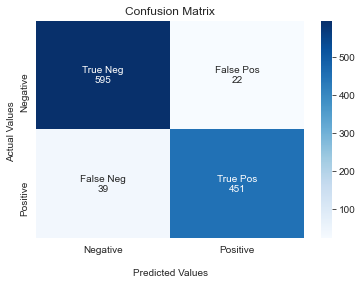

In [189]:
groups = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(val) for val in
                cf_matrix.flatten()]
labels = [f"{g1}\n{g2}" for g1, g2 in
          zip(groups, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
axes = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
axes.set_title('Confusion Matrix')
axes.set_xlabel('\nPredicted Values')
axes.set_ylabel('Actual Values ')
axes.xaxis.set_ticklabels(['Negative', 'Positive'])
axes.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

In [190]:
res_cfmatr = cf_matrix.flatten()
# precision = TP / (TP + FP)
precision = res_cfmatr[3] / (res_cfmatr[3] + res_cfmatr[1])
precision

0.9534883720930233

In [191]:
# recall = TP / (TP + FN)
recall = res_cfmatr[3] / (res_cfmatr[3] + res_cfmatr[2])
recall

0.9204081632653062

In [192]:
# f1 score = 2 * ((precision * recall)/ precision + recall)

f1score = 2 * ((precision * recall) / precision + recall)
f1score

3.6816326530612247

In [193]:
cross_val_scores = cross_val_score(logreg, X_scaled, y,cv=10)

In [194]:
log_cross_val_scores = np.average(cross_val_scores)
log_cross_val_scores


0.9123946918817014

## Random Forest Modelling and evaluation

In [195]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, random_state=42)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
y_train_pred = clf.predict(X_train)

In [196]:
# Model Accuracy
print(" Train Accuracy:",accuracy_score(y_train, y_train_pred) * 100)
print(" Test Accuracy:",accuracy_score(y_test, y_pred) * 100)
# from the train accuracy one can see that there is overfitting present because the accuracy
# is 100 % but the test accuracy is only 95.93 hence hyperparamater tuning is needed

 Train Accuracy: 100.0
 Test Accuracy: 95.39295392953929


In [197]:
cross_val = cross_val_score(clf,X_scaled,y,cv=10,scoring='accuracy').mean()
cross_val
# the cross validation score is very low and the train accuracy is 100 % so overfitting is present

0.8194356073995523

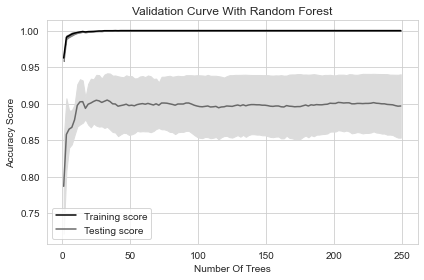

In [198]:
from sklearn.model_selection import validation_curve

# Create range of values for parameter
param_range = np.arange(1, 250, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(clf, 
                                             X_scaled, 
                                             y, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=10, 
                                             scoring="accuracy", 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Testing score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.savefig("overfitplot.png")
plt.show()

* from the graph above one can see the training scores are 100% but the testing scores are low so there is overfitting

## Random Forest Hyperparameter Tuning

In [199]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

In [200]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [201]:
n_estimators_list = list(range(10,220,50))
criterion_list = ['gini', 'entropy']
max_depth_list = list(range(5,41,10))
max_depth_list.append(None)
min_samples_split_list = [x/1000 for x in list(range(5, 41, 10))]
min_samples_leaf_list = [x/1000 for x in list(range(5, 41, 10))]
max_features_list = ['sqrt', 'log2']
bootstrap = [True, False]

params_grid = {
    'n_estimators': n_estimators_list,
    'criterion': criterion_list,
    'max_depth': max_depth_list,
    'min_samples_split': min_samples_split_list,
    'min_samples_leaf': min_samples_leaf_list,
    'max_features': max_features_list,
    'bootstrap': bootstrap
}

num_combinations = 1
for k in params_grid.keys(): num_combinations *= len(params_grid[k])

print('Number of combinations = ', num_combinations)
params_grid
# number of parameters to tune

Number of combinations =  3200


{'n_estimators': [10, 60, 110, 160, 210],
 'criterion': ['gini', 'entropy'],
 'max_depth': [5, 15, 25, 35, None],
 'min_samples_split': [0.005, 0.015, 0.025, 0.035],
 'min_samples_leaf': [0.005, 0.015, 0.025, 0.035],
 'max_features': ['sqrt', 'log2'],
 'bootstrap': [True, False]}

In [202]:
def my_accuracy_score(model, X, y): return accuracy_score(y, model.predict(X))

model_rscv = RandomizedSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),
                              param_distributions=params_grid,
                              n_iter=50,
                              cv=10,
                              scoring=my_accuracy_score,
                              return_train_score=True,
                              verbose=0)

model_rscv.fit(X_train,y_train)
# use RandomizedSearchCV on initialised parameters to find out best parameters

RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 15, 25, 35, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [0.005, 0.015,
                                                             0.025, 0.035],
                                        'min_samples_split': [0.005, 0.015,
                                                              0.025, 0.035],
                                        'n_estimators': [10, 60, 110, 160,
                                                         210]},
                   return_train_score=True,
                   scoring=<function my_accuracy_score at 0x7fee18f36af0>)

In [203]:
best_params_rscv = model_rscv.best_params_
best_params_rscv

{'n_estimators': 160,
 'min_samples_split': 0.025,
 'min_samples_leaf': 0.005,
 'max_features': 'sqrt',
 'max_depth': 25,
 'criterion': 'entropy',
 'bootstrap': False}

In [204]:
model_rscv_fin = RandomForestClassifier(class_weight='balanced',
                                      criterion=best_params_rscv['criterion'],
                                      max_depth=best_params_rscv['max_depth'],
                                      max_features=best_params_rscv['max_features'],
                                      min_samples_leaf=best_params_rscv['min_samples_leaf'],
                                      min_samples_split=best_params_rscv['min_samples_split'],
                                      n_estimators=best_params_rscv['n_estimators'],
                                        bootstrap = best_params_rscv['bootstrap']
                                       )
model_rscv_fin.fit(X_train,y_train)
# fit tuned parameters on train data

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=25, max_features='sqrt',
                       min_samples_leaf=0.005, min_samples_split=0.025,
                       n_estimators=160)

In [205]:
y_test_pred = model_rscv_fin.predict(X_test)

In [206]:
print('Test Accuracy Score = {:.4f}'.format(accuracy_score(y_test, y_test_pred) *100))
print('Train Accuracy Score = {:.4f}'.format(accuracy_score(y_train, model_rscv_fin.predict(X_train))*100))
# the overfitting problem has been resolved since now the model works well with both traing and test set

Test Accuracy Score = 95.9350
Train Accuracy Score = 95.7381


## Model Cross Validation

In [214]:
cross_val2=cross_val_score(model_rscv_fin,X_scaled,y,cv=10,scoring='accuracy').mean()
cross_val2
# the cross validation score is also good

0.912409420289855

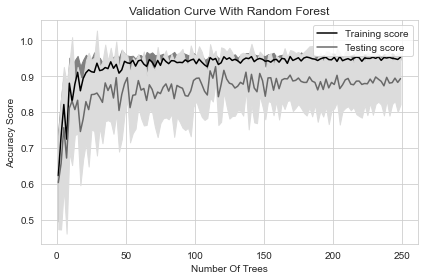

In [425]:
# Create range of values for parameter
param_range = np.arange(1, 250, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(model_rscv_fin, 
                                             X_scaled, 
                                             y, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=10, 
                                             scoring="accuracy", 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Testing score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

* from the graph above one can see that the model perfoms well on both training and test set

In [221]:
cf_matrix = confusion_matrix(y_test, y_test_pred)

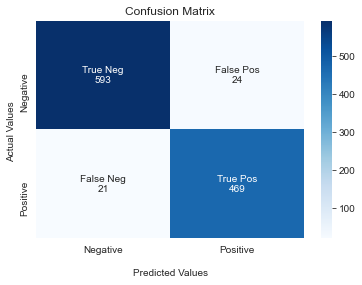

In [222]:
groups = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(val) for val in
cf_matrix.flatten()]
labels = [f"{g1}\n{g2}" for g1, g2 in
zip(groups,group_counts)]
labels = np.asarray(labels).reshape(2,2)
axes = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
axes.set_title('Confusion Matrix');
axes.set_xlabel('\nPredicted Values')
axes.set_ylabel('Actual Values ');
axes.xaxis.set_ticklabels(['Negative','Positive'])
axes.yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

* from the above confusion matrix, the number of false negative and false positives are low which further shows the model performed well

In [223]:
res_cfmatr = cf_matrix.flatten()
# precision = TP / (TP + FP)
precision = res_cfmatr[3]/ (res_cfmatr[3] + res_cfmatr[1])
precision

0.9513184584178499

In [224]:
# recall = TP / (TP + FN)
recall = res_cfmatr[3]/ (res_cfmatr[3] + res_cfmatr[2])
recall

0.9571428571428572

In [225]:
# f1 score = 2 * ((precision * recall)/ precision + recall)

f1score = 2 * ((precision * recall)/ precision + recall)
f1score

3.8285714285714287

## K-NN Classifier Modeling and evaluation 

In [365]:
from sklearn.preprocessing import MinMaxScaler
#Create copy of dataset.
df_model = new_combined_with_dums.copy()
#Rescaling features cases, recovered, population
scaler = MinMaxScaler()
features = [['cases', 'recovered', 'population']]
for feature in features:
    df_model[feature] = scaler.fit_transform(df_model[feature])

In [366]:
from sklearn.neighbors import KNeighborsClassifier

X=df_model.drop('deaths', axis = 1)  # Features
y=df_model['deaths']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
y_train_pred = neigh.predict(X_train)

In [367]:
# Model Accuracy
print("Test Accuracy:",accuracy_score(y_test, y_pred) * 100)
print("Train Accuracy:",accuracy_score(y_train, y_train_pred) * 100)

Test Accuracy: 90.60523938572719
Train Accuracy: 96.20302208446338


### KNN Cross Validation

In [426]:
cross_val_scores = cross_val_score(neigh, X, y,cv=10).mean()
cross_val_scores
# although the test and train accuracy are good the cross validation score is very low and 

0.6497083775185578

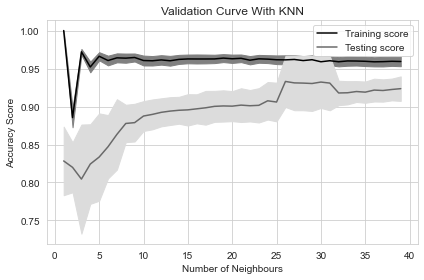

In [442]:
# Create range of values for parameter
param_range = np.arange(1, 40, 1)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(neigh, 
                                             X, 
                                             y, 
                                             param_name="n_neighbors", 
                                             param_range=param_range,
                                             cv=5, 
                                             scoring="accuracy", 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Testing score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With KNN")
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

* from the graph above one can clearly see overfitting because model performed well in training set but not on test set

## KNN Hyperparameter Tuning

In [369]:
KNeighborsClassifier().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [384]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,40))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

In [436]:
# Use Random Seach CV
def my_accuracy_score(model, X, y): return accuracy_score(y, model.predict(X))

knn = KNeighborsClassifier()
knn_rscv = RandomizedSearchCV(knn, hyperparameters, 
                              cv=10,
                              scoring=my_accuracy_score,
                              return_train_score=True, 
                                             n_jobs=-1)
knn_rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29, 30, ...],
                                        'p': [1, 2]},
                   return_train_score=True,
                 

In [437]:
knn_rscv_best_model = knn_rscv.best_estimator_.get_params()
knn_rscv_best_model
# find the best model paramaters

{'algorithm': 'auto',
 'leaf_size': 6,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 35,
 'p': 1,
 'weights': 'uniform'}

In [438]:
knn_rscv_fin = KNeighborsClassifier(n_neighbors=knn_rscv_best_model['n_neighbors'],
                                   leaf_size = knn_rscv_best_model['leaf_size'], 
                                    p = knn_rscv_best_model['p']
                                   )
knn_rscv_fin.fit(X_train,y_train)
# fit the new model

KNeighborsClassifier(leaf_size=6, n_neighbors=35, p=1)

In [439]:
y_test_pred_knn = knn_rscv_fin.predict(X_test)

In [440]:
print('Test Accuracy Score = {:.4f}'.format(accuracy_score(y_test, y_test_pred_knn) *100))
print('Train Accuracy Score = {:.4f}'.format(accuracy_score(y_train, knn_rscv_fin.predict(X_train))*100))
# fit the new model the accuracy for the test and train set is now balanced

Test Accuracy Score = 95.4833
Train Accuracy Score = 95.4669


## Model Cross Validation

In [444]:
cross_val3=cross_val_score(knn_rscv_fin,X,y,cv=10,scoring='accuracy').mean()
cross_val3
# there was a huge improvement of the previous accuracy

0.8381487863791681

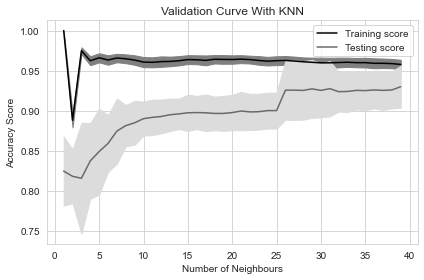

In [429]:
# Create range of values for parameter
param_range = np.arange(1, 40, 1)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(knn_rscv_fin, 
                                             X, 
                                             y, 
                                             param_name="n_neighbors", 
                                             param_range=param_range,
                                             cv=5, 
                                             scoring="accuracy", 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Testing score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With KNN")
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

* from the above graph one can see as the number of neighbors increased from 25 the testing accuracy was increasing towards the same accuracy of the traing set

In [445]:
cf_matrix = confusion_matrix(y_test, y_pred)

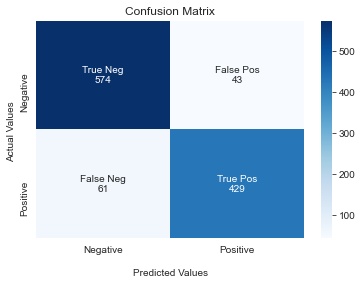

In [446]:
groups = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(val) for val in
cf_matrix.flatten()]
labels = [f"{g1}\n{g2}" for g1, g2 in
zip(groups,group_counts)]
labels = np.asarray(labels).reshape(2,2)
axes = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
axes.set_title('Confusion Matrix');
axes.set_xlabel('\nPredicted Values')
axes.set_ylabel('Actual Values ');
axes.xaxis.set_ticklabels(['Negative','Positive'])
axes.yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

In [447]:
res_cfmatr = cf_matrix.flatten()
# precision = TP / (TP + FP)
precision = res_cfmatr[3]/ (res_cfmatr[3] + res_cfmatr[1])
precision

0.9088983050847458

In [448]:
# recall = TP / (TP + FN)
recall = res_cfmatr[3]/ (res_cfmatr[3] + res_cfmatr[2])
recall

0.8755102040816326

In [449]:
# f1 score = 2 * ((precision * recall)/ precision + recall)

f1score = 2 * ((precision * recall)/ precision + recall)
f1score

3.5020408163265304

| Model               | Accuracy | Precision | Recall | F1    | Cross-valid |
|---------------------|----------|-----------|--------|-------|-------------|
| Logistic Regression | 68.83    | 0.64      | 0.66   | 2.66  | 0.70        |
| Random Forest       | 86.72    | 0.87      | 0.82   | 3.28  | 0.61        |
| KNN                 | 94.85    | 0.96      | 0.91   | 3.657 | 0.53        |

* Logistic Regression was not performing as expected as it is linear and our training data sets was not calibrated well enough.
* Random forest performed better but it has issues with overfitting.
* KNN performs the best as its neighboring method is expected to perform better in population data and our data was not high dimensional. 
* Cross validation results were not promising for KNN and further analysis need to be done to know what are the underlying reasons. 